# Train, test loading

In [8]:
import pandas as pd

print('loading train...', flush=True, end='')

# x를 loading해서 (batch_size, step, channel)
input_path = '../DL_model/dataset/preprocess3/input3-2/'
x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']
x_test = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
x_val = np.load(input_path+'x_val.npz', allow_pickle=True)['arr_0']
y_train = np.load(input_path+'y_train.npz')['arr_0']
y_test = np.load(input_path+'y_test_pacu.npz')['arr_0']
y_val = np.load(input_path+'y_val.npz')['arr_0']
print('done', flush=True)

x_test = np.transpose(x_test, [0,2,1])
x_test[:,:,0] = pd.DataFrame(x_test[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,1] = pd.DataFrame(x_test[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values


print('x_train shape:', x_train.shape)
print('x_test.shape:', x_test.shape)
print('x_val.shape:', x_val.shape)


# random shuffling - train set
ids = np.arange(x_train.shape[0])
np.random.shuffle(ids)

x_train = x_train[ids]
y_train = y_train[ids]


# random shuffling - vall set
ids = np.arange(x_val.shape[0])
np.random.shuffle(ids)

x_val = x_val[ids]
y_val = y_val[ids]


# random shuffling
ids = np.arange(x_test.shape[0])
np.random.shuffle(ids)

x_test = x_test[ids]
y_test = y_test[ids]
                          
                             
# ecg inputs
x_train_ecg = x_train[:,:,1:2]
x_test_ecg = x_test[:,:,1:2]
x_val_ecg = x_val[:,:,1:2]

        
# binary classification
y_train_bin = y_train >= 4
y_test_bin = y_test >= 4
y_val_bin = y_val >= 4

loading train...done
x_train shape: (78513, 5000, 2)
x_test.shape: (7617, 5000, 2)
x_val.shape: (8707, 5000, 2)


# GPU setting

In [3]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 4 Logical GPUs


# Model

## Training

In [10]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam as Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, LeakyReLU, ReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K


# hyperparamters
num_nodes = [64,64,64, 64] #, 64, 64, 64]
kernel_size = 3
pool_size = 2
BATCH_SIZE = 512
dense_node = 0
dropout_rate = 0.3
dropout_cnn = 0.3
dropout_fc = 0.3
learning_rate = 0.001


testname = '-'.join([str(num_node) for num_node in num_nodes])
print(testname)

# 출력 폴더를 생성
model_name = 'model(NRS4)_bin_'
for num_node in num_nodes:
    model_name += 'conv{}_'.format(num_node)
model_name += 'filter{}_3_bn_maxpool{}_globalmaxpool_dropout{}_dense{}_dropout{}_batch{}_lr_{}'.format(kernel_size, pool_size, dropout_cnn, dense_node, dropout_fc, BATCH_SIZE, learning_rate)

#model_name = 'model_reg_{}_{}_{}_size{}_relu_bn_maxpool{}_globalmaxpool_dense32_dropout{}_batch{}_learning_rate{}'.format(num_nodes[0], num_nodes[1], num_nodes[2], kernel_size, pool_size, dropout_rate, BATCH_SIZE, learning_rate)
save_path = "output/preprocess3/input3-2_PPG/1D_CNN_"+model_name

if not os.path.exists(save_path):
    os.mkdir(save_path)
weight_path = save_path + "/weights.hdf5"


# GPU 설정
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:1"])
with strategy.scope():
    
    # build a model
    model = Sequential()
    for num_node in num_nodes:
        model.add(Conv1D(filters=num_node, kernel_size=kernel_size, padding='same'))
        model.add(Conv1D(filters=num_node, kernel_size=kernel_size, padding='same'))
        #model.add(LeakyReLU(alpha=0.1))
        model.add(ReLU())
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=pool_size))
    #model.add(BatchNormalization())    
    model.add(GlobalMaxPool1D())
    #model.add(Flatten())
    model.add(Dropout(dropout_cnn))
    #model.add(Activation('sigmoid'))
    #model.add(Dropout(dropout_rate))
    if dense_node != 0:
        model.add(Dense(dense_node, activation='tanh'))
        model.add(Dropout(dropout_fc))
    model.add(Dense(1, activation='sigmoid'))

    
    # model 학습 설정
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=["acc", tf.keras.metrics.AUC()])
    hist = model.fit(x_train, y_train_bin, validation_data = (x_val, y_val_bin), epochs=100, batch_size=BATCH_SIZE, #class_weight={0:1, 1:3}, 
                            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

    #tf.keras.backend.clear_session()

model.load_weights(weight_path)
    
# 모델의 아키텍처 및 구조 저장
open(save_path + "/model.json", "wt").write(model.to_json())

# 전체 test 샘플을 한번에 예측
y_pred = model.predict(x_test).flatten()

# 결과를 저장
#np.savetxt(save_path+'/pred_y.txt', y_pred)


# 모델의 history log 저장 - binary classification
for key in hist.history.keys():
    if 'auc' in key and not 'val' in key:
        auc_key = key
#pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['accuracy'], hist.history['val_accuracy'], hist.history[auc], hist.history['val_'+auc]), open(save_path+'/history', 'wb'))

# 모델의 history log 저장 - regression
pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['acc'], hist.history['val_acc'], hist.history[auc_key], hist.history['val_'+auc_key]), open(save_path+'/history', 'wb'))


64-64-64-64
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:1',)
Epoch 1/100
154/154 [==============================] - ETA: 0s - loss: 0.7099 - acc: 0.7025 - auc_1: 0.7166
Epoch 00001: val_loss improved from inf to 1.20419, saving model to output/preprocess3/input3-2_PPG/1D_CNN_model(NRS4)_bin_conv64_conv64_conv64_conv64_filter3_3_bn_maxpool2_globalmaxpool_dropout0.3_dense0_dropout0.3_batch512_lr_0.001/weights.hdf5
154/154 [==============================] - 28s 183ms/step - loss: 0.7099 - acc: 0.7025 - auc_1: 0.7166 - val_loss: 1.2042 - val_acc: 0.6264 - val_auc_1: 0.7093
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 0.5353 - acc: 0.7550 - auc_1: 0.7485
Epoch 00002: val_loss improved from 1.20419 to 0.71037, saving model to output/preprocess3/input3-2_PPG/1D_CNN_model(NRS4)_bin_conv64_conv64_conv64_conv64_filter3_3_bn_maxpool2_globalmaxpool_dropout0.3_dense0_dropout0.3_batch512_lr_0.001/weights.hdf5
154/154 [===

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 5000, 64)          448       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 5000, 64)          12352     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 5000, 64)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 5000, 64)          256       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2500, 64)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 2500, 64)          12352     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 2500, 64)         

## Model evaluation

test set accuracy:0.71
test set auroc: 0.5579942644144978


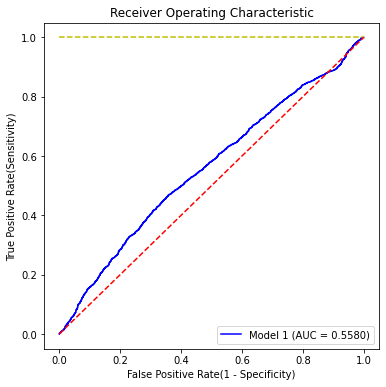

In [12]:
from sklearn.metrics import roc_curve, auc, r2_score
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt

### Classification
# Model Accuracy of test set
model_y = y_pred>=0.5
acc_val = np.mean(model_y==y_test_bin)
print('test set accuracy:{:.2f}'.format(acc_val))


# Model AUROC
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('test set auroc:', roc_auc)

# Model R_square
#print('test set R2:', r2_score(y_test, y_pred*9))


# Adding evaluation results to file name
# classification
#os.rename(save_path, save_path+'_auc{:.4f}_acc{:.4f}'.format(roc_auc,np.mean(model_y==y_test_bin)))

# regression
os.rename(save_path, 'output/preprocess3/input3-2_PPG/auc{:.4f}_1D_CNN_{}acc{:.2f}'.format(roc_auc,model_name,acc_val))


# plotting roc
plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic')
plt.xlabel("False Positive Rate(1 - Specificity)")
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')

plt.legend(loc='lower right')
plt.show()

## Model History Plot

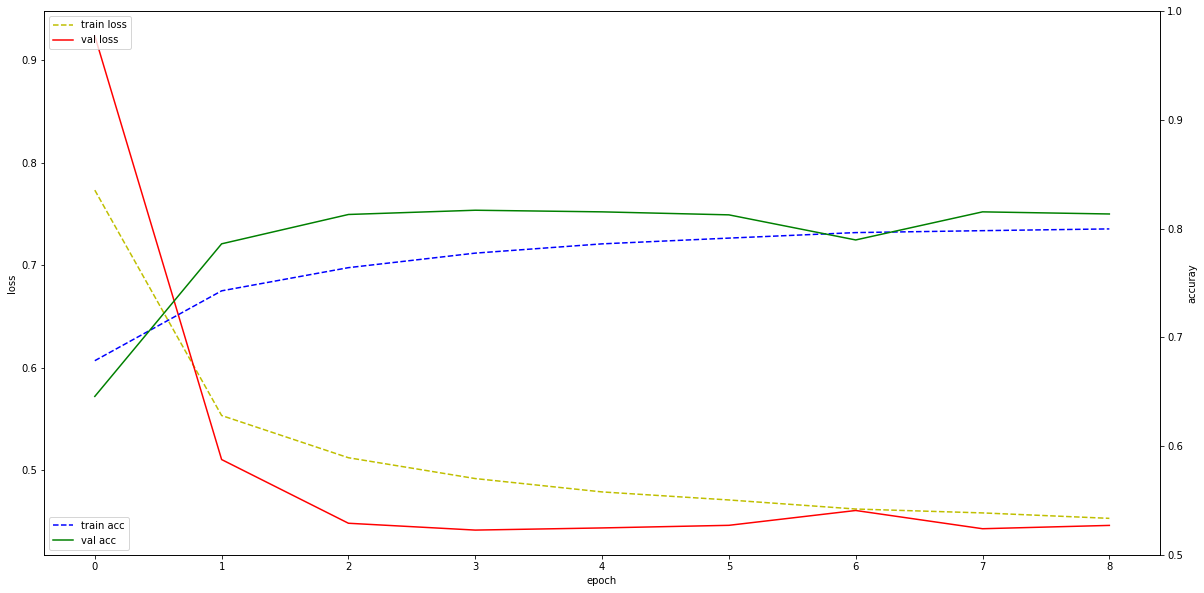

In [6]:
# model auroc 0.719짜리
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(20,10))

#x-axis는 공유하지만 y-axis는 공유x
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', linestyle='dashed', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

#acc_ax.plot(hist.history['mean_absolute_error'], 'b', linestyle='dashed',label='train mae')
#acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val mae')
acc_ax.plot(hist.history['acc'], 'b', linestyle='dashed',label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylim(0.5,1.0)
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## 검증

In [26]:
test_result = model.evaluate(x=x_test, y=y_test_bin, batch_size=512, verbose=1, sample_weight=None, steps=None, callbacks=None)



27/27 [==============================] - 2s 71ms/step - loss: 3.0123 - acc: 0.6256 - auc_6: 0.6727


In [27]:
train_result = model.evaluate(x=x_train[-13130:], y=y_train_bin[-13130:], batch_size=512, verbose=1, sample_weight=None, steps=None, callbacks=None)



26/26 [==============================] - 2s 69ms/step - loss: 0.0831 - acc: 0.9710 - auc_6: 0.9956


In [31]:
y_val_pred = model.predict(x_train[-13130:]).flatten()
y_val_pred = y_val_pred>=0.5

np.mean(y_train_bin[-13130:]==np.array(y_val_pred))

0.970982482863671

In [32]:
print('y_train의 평균: {:.4f}, y_test의 평균: {:.4f}'.format(np.mean(y_train_bin), np.mean(y_test_bin)))
print('y_val의 평균: {:.4f}'.format(np.mean(y_train_bin[-13130:])))

y_train의 평균: 0.4847, y_test의 평균: 0.4669
y_val의 평균: 0.4855


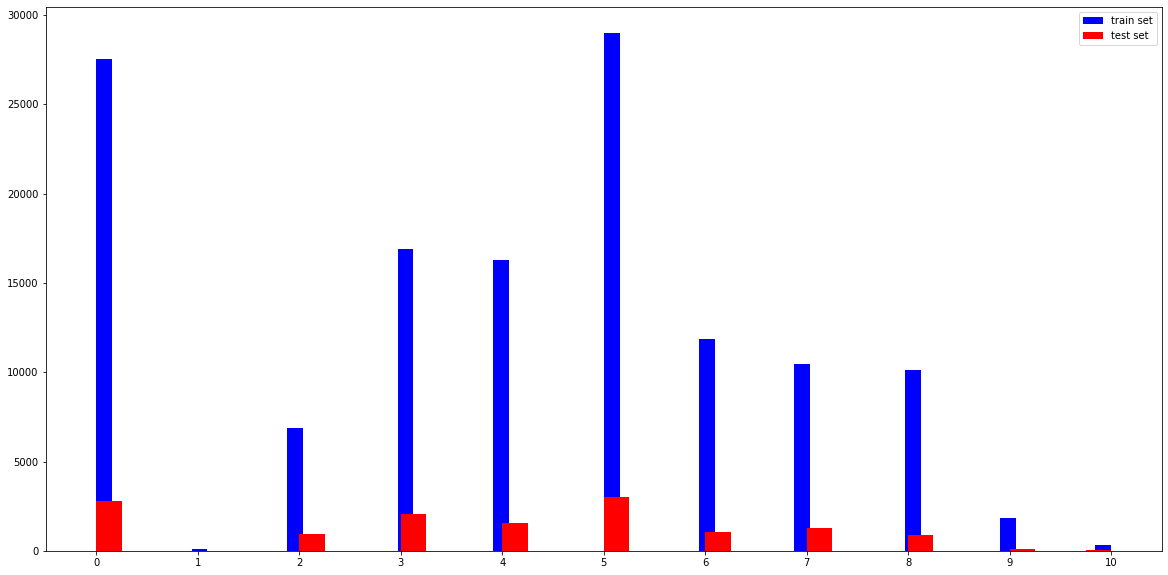

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.hist(y_train, bins='auto', color='b', label='train set')
plt.hist(y_test, bins='auto', color='r', label='test set')
plt.xticks(np.arange(0,11))
plt.legend(loc='best')

plt.figure(figsize=(20,10))
plt.hist(y_train, bins='auto', color='b', label='train set')
plt.hist(y_test, bins='auto', color='r', label='test set')
plt.xticks(np.arange(0,11))
plt.legend(loc='best')

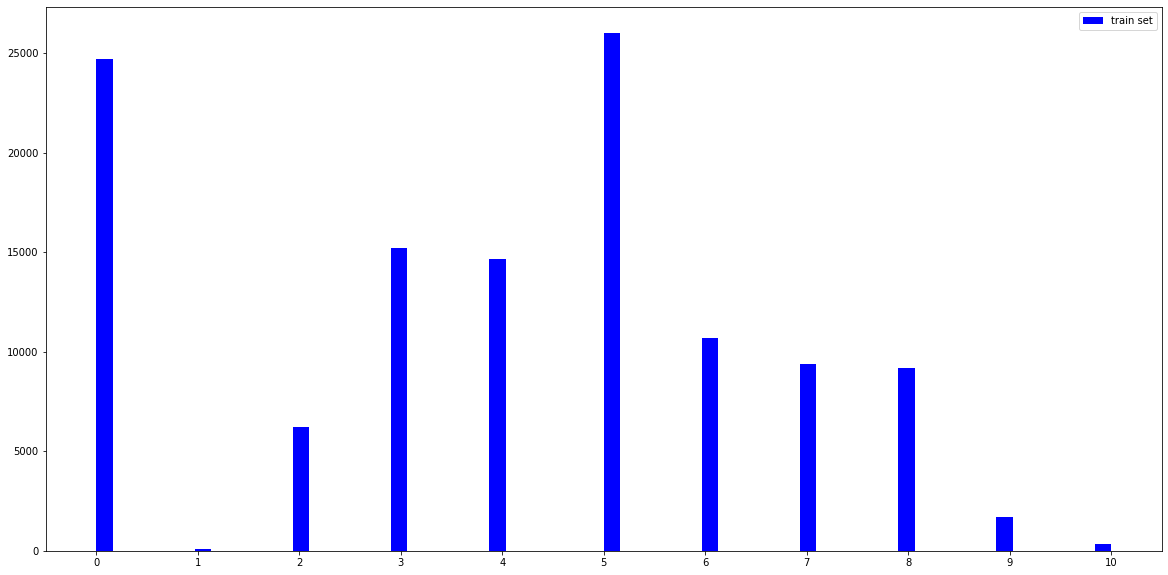

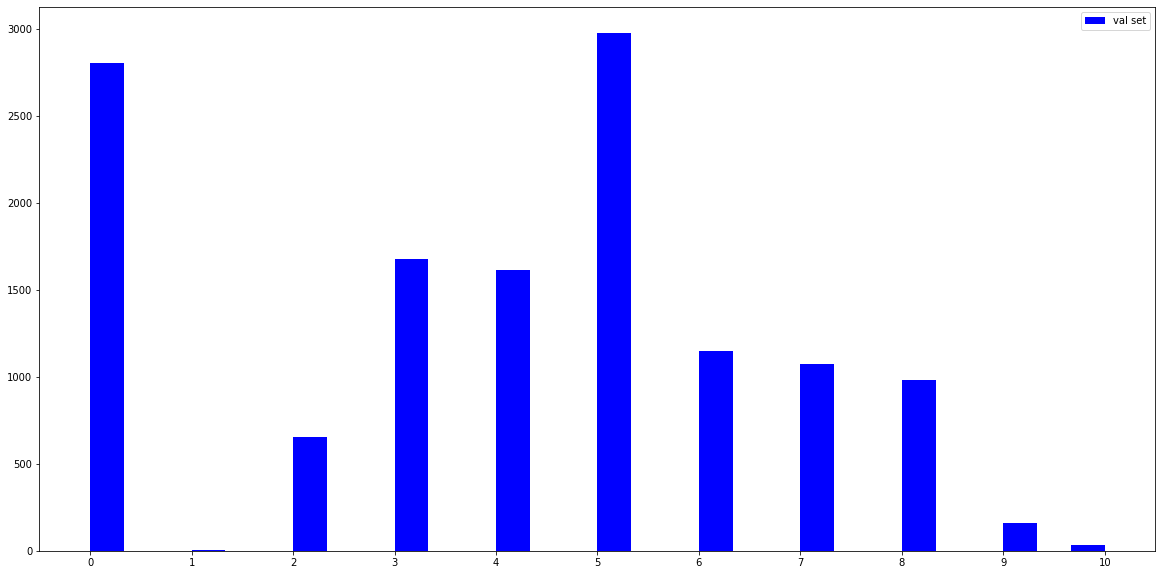

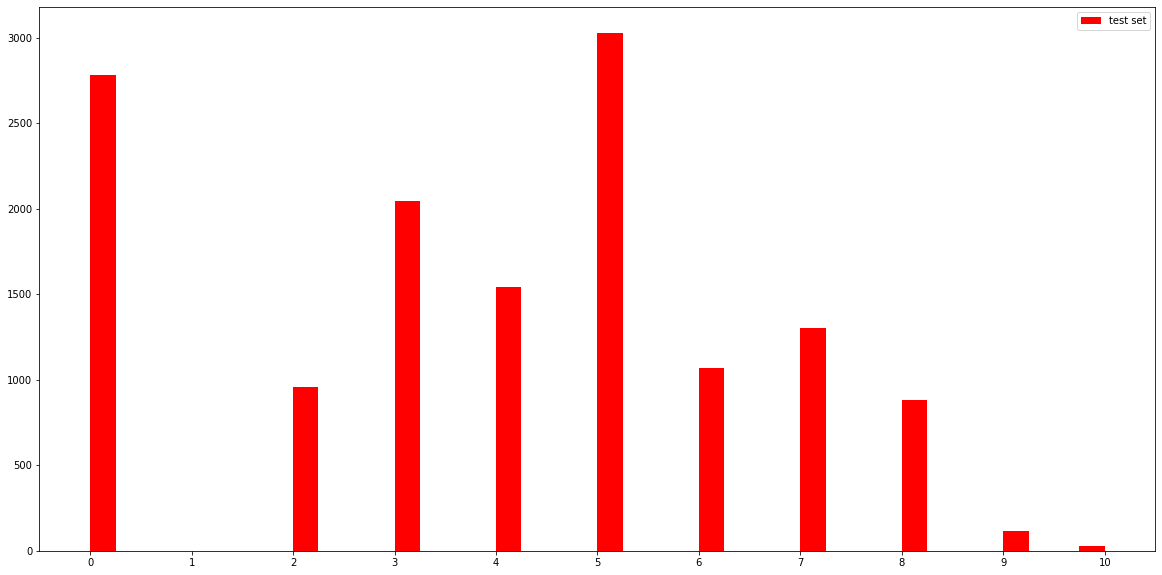

In [41]:
plt.figure(figsize=(20,10))
plt.hist(y_train[:-13130], bins='auto', color='b', label='train set')
plt.xticks(np.arange(0,11))
plt.legend(loc='best')

plt.figure(figsize=(20,10))
plt.hist(y_train[-13130:], bins='auto', color='b', label='val set')
plt.xticks(np.arange(0,11))
plt.legend(loc='best')



plt.figure(figsize=(20,10))
plt.hist(y_test, bins='auto', color='r', label='test set')
plt.xticks(np.arange(0,11))
plt.legend(loc='best')

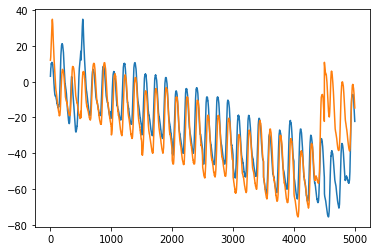

In [51]:
plt.plot(x_test[0,:,0])
plt.plot(x_test[1,:,0])
plt.show()

In [61]:
input_path = 'dataset/preprocess2/input3-2/'

# loading pacu
print('loading pacu data...', flush=True, end='')
x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']

loading pacu data...

In [9]:
np.mean(x_train[400,:,0])

1.8310548e-08

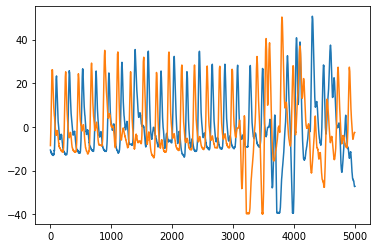

In [65]:
plt.plot(x_train_pacu[0,0,:])
plt.plot(x_train_pacu[1,0,:])
plt.show()